<!-- # pip install -U jedi==0.17.2 -->

# SageMaker Hosting を利用して TensorFlow のモデルを hosting する
pretrained モデルである MobileNet (とv2)を題材にする

## 使用するモジュールのインストールと読み込み、定数の設定

In [1]:
pip install -U jedi==0.17.2 matplotlib boto3 sagemaker

     |████████████████████████████████| 131 kB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 438 kB 78.7 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 564 kB/s  eta 0:00:01
     |████████████████████████████████| 7.8 MB 50.3 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.55.0-py2.py3-none-any.whl size=614624 sha256=accd569e4d29c1003c352e78c2d9b2ef6dd028da0274556aeefbe75cddb130ab
  Stored in directory: /root/.cache/pip/wheels/9b/1a/06/97744f7e84779e9f4dbff3dd470fdf5dfb283fdb6060a1c49b
Successfully built sagemaker
  Attempting uninstall: botocore
    Found existing installation: botocore 1.20.89
    Uninstalling botocore-1.20.89:
      Successfully uninstalled botocore-1.20.89
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.4.2
    Uninstalling s3transfer-0.4.2:
      Successfully uninstalled s3transfer-0.4.2
  Attempting uninstall: boto3
    Found existing installation: boto3 1.17.89
    Uninstalling

In [43]:
import tensorflow as tf, os, tarfile, json, numpy as np, base64, sagemaker, boto3
from sagemaker.tensorflow import TensorFlowModel
from io import BytesIO
from matplotlib import pyplot as plt
from PIL import Image
from time import sleep
sm_client = boto3.client('sagemaker')
smr_client = boto3.client('sagemaker-runtime')
s3_client = boto3.client('s3')
sm_role = sagemaker.get_execution_role()
sess = sagemaker.session.Session()
bucket = sess.default_bucket()

## 使用するモデルのロードと動作確認

In [4]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

[2021-08-25 10:59:40.171 tensorflow-2-3-cpu-py3-ml-m5-large-1aa9dde2994c48e8f49a179e592d:336 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-25 10:59:40.325 tensorflow-2-3-cpu-py3-ml-m5-large-1aa9dde2994c48e8f49a179e592d:336 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_____________

In [5]:
work_dir = f'{os.getcwd()}/work/'

os.makedirs(work_dir, exist_ok=True)
# サンプル画像をダウンロード
file = tf.keras.utils.get_file(
    f'{work_dir}cat.jpg',
    'https://gahag.net/img/201608/11s/gahag-0115329292-1.jpg')

# 分類クラスをダウンロード
labels_path = tf.keras.utils.get_file(
    f'{work_dir}/ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels = list(np.array(open(labels_path).read().splitlines())[1:])

In [6]:
with open('./code/labels.txt','wt') as f:
    for txt in labels:
        f.write(txt+'\n')

In [7]:
imsize = Image.open(file).size

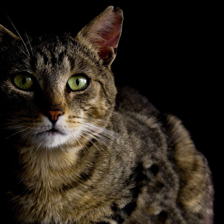

In [8]:
# 画像のresizeと前処理結果の確認
x,y = imsize[0]-imsize[1],0
img = Image.open(file).crop((x,y,900,537)).resize((model.input_shape[1],model.input_shape[2]))
img_arr = ((np.array(img)-127.5)/127.5).astype(np.float32).reshape(-1,model.input_shape[1],model.input_shape[2],3)
img

In [9]:
# モデルの動作確認
print(labels[np.argmax(model.predict(img_arr))]) # tabby

tabby


## TensorFlow の SageMaker マネージドコンテナ(TensorFlow Serving)を利用した hosting
* コンテナの詳細は[こちら](https://github.com/aws/sagemaker-tensorflow-serving-container)
* SageMaker SDK と boto3 を利用した場合それぞれ行う

### SageMaker SDK の場合の手順概要
1. SavedModel 形式でモデルを保存
2. モデルを tar.gz で固める
3. S3 にモデルをアップロード
4. SageMaker SDK の [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html?highlight=TensorFlowModel#sagemaker.tensorflow.model.TensorFlowModel) API で S3 に配置したモデルを読み込む
5. [deploy](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html?highlight=TensorFlowModel#sagemaker.tensorflow.model.TensorFlowModel.deploy) メソッドで推論エンドポイントを作成
6. 推論実行
7. 推論エンドポイントを削除

In [14]:
# 保存ディレクトリを指定
model_dir = './mobilenet/0001'

# tar.gz の出力先を指定
tar_dir = 'MyModel'
os.makedirs(tar_dir, exist_ok=True)
tar_name = os.path.join(tar_dir, 'model.tar.gz')

# モデルを SavedModel 形式で保存
model.save(model_dir)

# tar.gz ファイルを出力
with tarfile.open(tar_name, mode='w:gz') as tar:
    tar.add(model_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./mobilenet/0001/assets


INFO:tensorflow:Assets written to: ./mobilenet/0001/assets


In [15]:
# S3 にアップロードして、返り値としてS3のURIを受け取る
model_s3_path = f's3://{bucket}/{tar_dir}'

model_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = tar_name,
    desired_s3_uri = model_s3_path
)

print(model_s3_uri)


s3://sagemaker-ap-northeast-1-155580384669/MyModel/model.tar.gz


In [16]:
# Sagemaker SDK でマネージドコンテナの URI を取得
container_image_tf24_uri = sagemaker.image_uris.retrieve(
    "tensorflow",  # TensorFlow のマネージドコンテナを利用
    sagemaker.session.Session().boto_region_name, # ECR のリージョンを指定
    version='2.4', # TensorFlow のバージョンを指定
    instance_type = 'ml.m5.large', # インスタンスタイプを指定
    image_scope = 'inference' # 推論コンテナを指定
)

print(container_image_tf24_uri)


763104351884.dkr.ecr.ap-northeast-1.amazonaws.com/tensorflow-inference:2.4-cpu


In [17]:
model_name = 'MyTFModelFromSMSDK'
endpoint_config_name = model_name + 'Endpoint'
endpoint_name = endpoint_config_name

In [ ]:
# モデルとコンテナの指定
tf_model = TensorFlowModel(
    name = model_name,
    model_data=model_s3_uri, # モデルの S3 URI
    role= sm_role, # 割り当てるロール
    image_uri = container_image_tf24_uri, # コンテナイメージの S3 URI
)
# デプロイ(endpoint 生成)
predictor = tf_model.deploy(
    endpoint_name=endpoint_name, # エンドポイントの名前
    initial_instance_count=1, # インスタンス数
    instance_type='ml.m5.large', # インスタンスタイプ
)


In [ ]:
img = Image.open(file).resize((model.input_shape[1],model.input_shape[2]))
img_arr = ((np.array(img)-127.5)/127.5).astype(np.float32).reshape(-1,model.input_shape[1],model.input_shape[2],3)

In [ ]:
result = np.argmax(predictor.predict(img_arr)['predictions'][0])
print(labels[result])

In [ ]:
r = sm_client.delete_endpoint(EndpointName=endpoint_name)
r = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
r = sm_client.delete_model(ModelName=model_name)

### boto3 の場合の手順概要
1. SavedModel 形式でモデルを保存(済)
2. モデルを tar.gz で固める(済)
3. S3 にモデルをアップロード(済)
4. boto3 の [create_model](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model) メソッドで SageMaker のサービスに S3 にアップロードしたモデルを登録する
5. boto3 の [create_endpoint_config](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint_config)で推論エンドポイントの設定を作成する
6. boto3 の [create_endpoint](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint)で推論エンドポイントを作詞絵する
7. boto3の[invoke_endpoint](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker-runtime.html#SageMakerRuntime.Client.invoke_endpoint)で推論する
8. 推論エンドポイントを削除

In [ ]:
model_name = 'MyTFModelAddProcessFromBoto3'
endpoint_config_name = model_name + 'EndpointConfig'
endpoint_name = model_name + 'Endpoint'

In [ ]:
response = sm_client.create_model(
    ModelName=model_name,
    PrimaryContainer={
        # SageMaker SDK の時と同じ URI を指定
        'Image': container_image_tf24_uri,
        # SageMaker SDK の時と同じ URI を指定
        'ModelDataUrl': model_s3_uri,
    },
    # SageMaker SDK の時と同じ role を指定
    ExecutionRoleArn=sm_role,
)


In [ ]:
response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
)


In [ ]:
response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)
while True:
    status = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    if status in ['InService','RollingBack','SystemUpdating','OutOfService']:
        print('!')
        print(status)
        break
    else:
        print('.',end='')
        sleep(5)

In [ ]:
# リストを文字列にして渡すパターン
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : str(img_arr.tolist())
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

In [ ]:
# jsonにして渡すパターン
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

In [ ]:
# リソース削除
r = sm_client.delete_endpoint(EndpointName=endpoint_name)
r = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
r = sm_client.delete_model(ModelName=model_name)

## 前処理/後処理追加
* リスト形式でデータを作成し(た後で json形式に変換し)て predict を行うが、 inference.py を使うことで前処理/後処理を endpoint 側うことも可能。
  * 重い画像の前処理を潤沢なエンドポイントのコンピューティングリソースで実行することで、呼び出し側　(Lambda など)の頻繁かつ長期的に処理するコンピューティングリソースのスペックを低減できる
  * 呼び出し側が前処理を意識せずに実装できるようになる(呼び出し側はデータサイエンティストの領域に入らずに済み、エンドポイントで実行する前処理までをDSの領域にできる）
* 以下を例に実装する。  
    * 前処理の例）画像分類であれば、画像のバイナリデータを base64 エンコーディングしたものを直接送りつけて、 endpoint 側でリストに変換可能
    * 後処理の例）softmax の結果から一番可能性の高い値を取得し、そのインデックスからラベルに変換する

### SageMaker Python SDK でホスティング
手順は処理無しの場合と同じで、TensorFlowModel APIでモデルを読み込む際、前処理/後処理を記載したinference.pyとそのディレクトリを指定する

In [ ]:
!pygmentize ./code/inference.py

In [ ]:
model_name = 'MyTFModelAddProcessFromSMSDK'
endpoint_config_name = model_name + 'Endpoint'
endpoint_name = endpoint_config_name

In [ ]:
# tar.gz の出力先を指定
tar_dir = 'MyModelAddProcess'
code_dir = './code'
os.makedirs(tar_dir, exist_ok=True)
tar_name = os.path.join(tar_dir, 'model.tar.gz')
with tarfile.open(tar_name, mode='w:gz') as tar:
    tar.add(model_dir)

In [ ]:
model_add_process_s3_path = f's3://{bucket}/{tar_dir}'

model_add_process_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = tar_name,
    desired_s3_uri = model_add_process_s3_path
)
print(model_add_process_s3_uri)

#### inference.py と必要なファイルの設定
* entry_point 引数で `inference.py` (名前固定)を指定すると `input_handler` と `output_handler` を推論前後に実行してくれる
* 必要なモジュール等がある場合は `source_dir` 引数に格納してあるディレクトリを指定すると一緒に読み込むが、 inference.py が `source_dir` のルートに存在する必要がある
* ホスティング先の展開ディレクトリは `/opt/ml/model/code` になるので、テキストファイルを読み込む時は絶対パスで指定するとよい（カレントディレクトリは `/sagemaker` で実行される）

In [ ]:
# モデルとコンテナの指定
tf_model = TensorFlowModel(
    name = model_name,
    model_data=model_add_process_s3_uri, # モデルの S3 URI
    role= sm_role, # 割り当てるロール
    image_uri = container_image_tf24_uri, # コンテナイメージの S3 URI
    entry_point = './code/inference.py',
    source_dir = './code/'
)
# デプロイ(endpoint 生成)
predictor = tf_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1, # インスタンス数
    instance_type='ml.m5.xlarge', # インスタンスタイプ
)


In [ ]:
# 推論
with open('./work/cat.jpg', 'rb') as img:
    data = img.read()
bio = BytesIO()
bio.write(data)
b64_data = base64.b64encode(bio.getvalue()).decode('utf-8')
json_b64 = json.dumps({'b64_image':b64_data})
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : json_b64
}
response = smr_client.invoke_endpoint(**request_args)
print(response['Body'].read().decode('utf-8'))

In [ ]:
# すでにあった場合の削除
r = sm_client.delete_endpoint(EndpointName=endpoint_name)
r = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
r = sm_client.delete_model(ModelName=model_name)

### Boto3 でホスティングと推論

In [ ]:
model_name = 'MyTFModelAddProcessFromBoto3'
endpoint_config_name = model_name + 'EndpointConfig'
endpoint_name = model_name + 'Endpoint'

#### `inference.py` 他を `model.tar.gz` に同包
boto3 から endpoint を作成する場合は、SageMaker SDK のように `entry_point` や `source_dir` の設定ができないため、 必要なファイルは予め `model.tar.gz` に一緒に入れる必要がある  
(SageMaker SDK の場合は裏側で自動で `inference.py` などを model.tar.gz に再度固めて s3 にアップロードしてくれている)

In [ ]:
# model.tar.gz にモデルなどを固める
tar_dir = 'MyModelAddProcess'
code_dir = './code'
os.makedirs(tar_dir, exist_ok=True)
tar_name = os.path.join(tar_dir, 'model.tar.gz')
with tarfile.open(tar_name, mode='w:gz') as tar:
    tar.add(model_dir)
    tar.add(code_dir) # inference.py などを同包

In [ ]:
model_add_process_s3_path = f's3://{bucket}/{tar_dir}'

model_add_process_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = tar_name,
    desired_s3_uri = model_add_process_s3_path
)
print(model_add_process_s3_uri)

In [ ]:
response = sm_client.create_model(
    ModelName=model_name,
    PrimaryContainer={
        # SageMaker SDK の時と同じ URI を指定
        'Image': container_image_tf24_uri,
        # SageMaker SDK の時と同じ URI を指定
        'ModelDataUrl': model_add_process_s3_uri,
    },
    # SageMaker SDK の時と同じ role を指定
    ExecutionRoleArn=sm_role,
)
response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
)
response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)

while True:
    status = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    if status in ['InService','RollingBack','SystemUpdating','OutOfService']:
        print('!')
        print(status)
        break
    else:
        print('.',end='')
        sleep(5)

In [ ]:
# 推論
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'Body' : json_b64
}
response = smr_client.invoke_endpoint(**request_args)
print(response['Body'].read().decode('utf-8'))

In [ ]:
# 削除
r = sm_client.delete_endpoint(EndpointName=endpoint_name)
r = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
r = sm_client.delete_model(ModelName=model_name)

## マルチモデルエンドポイント
* １つの推論インスタンスに複数のモデルをデプロイすることが可能
* モデルごとにtar.gzにかためて、S3 の指定プレフィックス直下に配置する
* 以下は boto3 の例。SageMaker SDK でもマルチモデルエンドポイントは可能で詳細は[こちら](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/deploying_tensorflow_serving.html?highlight=multi%20model#deploying-more-than-one-model-to-your-endpoint)
* エンドポイント作成手順はシングルモデルと変わらないが、それぞれのモデルを {モデル名}.tar.gz に固めた上で同じキープレフィックスに配置し、create_model する際の引数に、tar.gzを配置しているプレフィックス(tar.gzのオブジェクトのURIではない）を指定する
* 呼び出す(invoke_endpoint)する際にモデルのファイル名を指定する


### モデル準備と動作確認( mobilenetv2 )
新しくmobilenetv2を追加し、mobilenetとmobilenetv2の2モデルを１つのエンドポイントでホスティングする準備

In [ ]:
model2 = tf.keras.applications.mobilenet_v2.MobileNetV2()
model2.summary()

In [ ]:
# モデルの動作確認(v1との比較)
# mobilenet
prediction = model.predict(img_arr)[0]
print(prediction[np.argmax(prediction)],labels[np.argmax(prediction)])
# mobilenetV2
prediction = model2.predict(img_arr)[0]
print(prediction[np.argmax(prediction)],labels[np.argmax(prediction)])

In [ ]:
# 保存ディレクトリを指定
model2_dir = './mobilenetv2/0001'

# mobilenetv2.tar.gz の出力先を指定
tar_dir = 'MyMultiModel'
os.makedirs(tar_dir, exist_ok=True)
tar_name = os.path.join(tar_dir, 'mobilenetv2.tar.gz')

# モデルを SavedModel 形式で保存
model2.save(model2_dir)

# tar.gz ファイルを出力
with tarfile.open(tar_name, mode='w:gz') as tar:
    tar.add(model2_dir, arcname="0001")

# mobilenet.tar.gz の出力先を指定
tar_name = os.path.join(tar_dir, 'mobilenet.tar.gz')
# tar.gz ファイルを出力
with tarfile.open(tar_name, mode='w:gz') as tar:
    tar.add(model_dir, arcname="0001")

In [ ]:
# mobilenet と mobilenet v2 をそれぞれ S3 にアップロードする
multi_model_s3_path = f's3://{bucket}/{tar_dir}/'

!aws s3 cp ./MyMultiModel/ {multi_model_s3_path} --recursive

In [ ]:
model_name = 'MyMultiModel'
endpoint_config_name = model_name + 'EndpointConfig'
endpoint_name = model_name + 'Endpoint'

### モデルの作成～エンドポイント作成
* シングルモデルのときはtar.gzのパスを指定していたが、マルチモデルのときはモデルを保存しているプレフィックスを指定する
* 他はシングルモデルと同じ

In [ ]:
response = sm_client.create_model(
    ModelName=model_name,
        PrimaryContainer={
        'Image': container_image_tf24_uri,
        'Mode':'MultiModel',
        'ModelDataUrl': multi_model_s3_path, # tar.gz を配置している S3 パスを指定
    },
    ExecutionRoleArn=sm_role,
)
response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
)
response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)

while True:
    status = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    if status in ['InService','RollingBack','SystemUpdating','OutOfService']:
        print('!')
        print(status)
        break
    else:
        print('.',end='')
        sleep(5)

### マルチモデルエンドポイントでの推論
* `TargetModel` 引数にtar.gzに固めたモデルのファイル名を入れればそのモデルが使用される

In [ ]:
# mobilenet推論
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'TargetModel' : 'mobilenet.tar.gz',
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

In [ ]:
# mobilenetv2推論
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'TargetModel' : 'mobilenetv2.tar.gz',
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

### モデルの追加
* 同じプレフィックス下に新しくモデルを追加すれば追加したモデルで推論可能
* ここでは mobilenetv2 を別名に差し替えて(mobilenetv2**_2**)、追加でアップロードしてそちらも機能することを確認する

注１）モデルの削除は S3 から削除すればできるが、タイムラグがかなりあるので注意。モデルをホスティングをしているインスタンスからモデルが削除されない限り（コントロールできない領域で、ホスティングしているインスタンスのメモリ/ストレージが不足したときのみ自動で読み込んでいるモデルが削除される）S3から削除したモデルで推論できる。  
注２）同様にモデルの更新についても、S3に配置したモデルを上書き保存しても古いモデルがうごき続けてしまう可能性がある。[公式のメッセージ](https://docs.aws.amazon.com/sagemaker/latest/dg/add-models-to-endpoint.html)としては「上書き保存はするな」

In [ ]:
!aws s3 cp ./MyMultiModel/mobilenetv2.tar.gz {multi_model_s3_path}mobilenetv2_2.tar.gz

In [ ]:
# mobilenet推論
request_args = {
    'EndpointName': endpoint_name,
    'ContentType' : 'application/json',
    'Accept' : 'application/json',
    'TargetModel' : 'mobilenetv2_2.tar.gz', # 後から追加したモデル
    'Body' : json.dumps({"instances": img_arr.tolist()})
}
response = smr_client.invoke_endpoint(**request_args)
predictions = json.loads(response['Body'].read().decode('utf-8'))['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

In [ ]:
r = sm_client.delete_endpoint(EndpointName=endpoint_name)
r = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
r = sm_client.delete_model(ModelName=model_name)

### 非同期推論
* endpoint を常時立ち上げておくのではなく、inference する時だけ立ち上げて、推論が終わるとendpointを落とす方法
* バッチ変換(batch transform)と近いが、バッチ変換はデータが溜まっている前提で一気に動かすのに対して、個別のデータに対して数分オーダで推論結果を求められる場合に適する（非同期推論は数GBのリクエストでも返すことが可能）
* 詳細は[こちら](https://aws.amazon.com/jp/about-aws/whats-new/2021/08/amazon-sagemaker-asynchronous-new-inference-option/)
* 使い方はリアルタイム推論に近いが、endpoint_configで設定をいじる必要がある

In [56]:
model_name = 'MyTFModelFromBoto3Async'
endpoint_config_name = model_name + 'EndpointConfig'
endpoint_name = model_name + 'Endpoint'

### モデルの作成
リアルタイム推論と同じ

In [57]:
response = sm_client.create_model(
    ModelName=model_name,
    PrimaryContainer={
        # SageMaker SDK の時と同じ URI を指定
        'Image': container_image_tf24_uri,
        # SageMaker SDK の時と同じ URI を指定
        'ModelDataUrl': model_s3_uri,
    },
    # SageMaker SDK の時と同じ role を指定
    ExecutionRoleArn=sm_role,
)

ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Cannot create already existing model "arn:aws:sagemaker:ap-northeast-1:155580384669:model/mytfmodelfromboto3async".

### 推論エンドポイントの設定
`AsyncInferenceConfig` という引数で、推論結果を配置するS3の出力先を指定する

In [58]:
response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': 'AllTrafic',
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.xlarge',
        },
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            # Location to upload response outputs when no location is provided in the request.
            "S3OutputPath": f"s3://{bucket}/async_inference/output"
        },
    }
)


### 推論エンドポイントの作成
リアルタイム推論と同じ

In [59]:
response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)

while True:
    status = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    if status in ['InService','RollingBack','SystemUpdating','OutOfService']:
        print('!')
        print(status)
        break
    else:
        print('.',end='')
        sleep(5)

....................!
InService


### 非同期推論実行
事前にS3に推論データを配置して、`invoke_endpoint_async`で非同期推論を実行する

In [60]:
json_name = './tabby.json' 
with open(json_name,'wt') as f:
    f.write(json.dumps({"instances": img_arr.tolist()}))
tabby_s3_uri = sagemaker.s3.S3Uploader.upload(
    local_path = json_name,
    desired_s3_uri = f"s3://{bucket}/async_inference/input"
)

In [65]:
%%time
response = smr_client.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=tabby_s3_uri,
    ContentType='application/json'
)
output_s3_uri = response['OutputLocation']
output_key = output_s3_uri.replace(f's3://{bucket}/','')
while True:
    result = s3_client.list_objects(Bucket=bucket, Prefix=output_key)
    exists = True if "Contents" in result else False
    if exists:
        obj = s3_client.get_object(Bucket=bucket, Key=output_key)
        predictions = json.loads(obj['Body'].read().decode())['predictions'][0]
        print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])
        break
    else:
        print('.')
        sleep(0.1)

.
.
tabby 0.557726264
CPU times: user 24.4 ms, sys: 0 ns, total: 24.4 ms
Wall time: 580 ms


In [62]:
obj = s3_client.get_object(Bucket=bucket, Key=output_key)
predictions = json.loads(obj['Body'].read().decode())['predictions'][0]
print(labels[np.argmax(predictions)],predictions[np.argmax(predictions)])

tabby 0.557726264


In [52]:
r = sm_client.delete_endpoint(EndpointName=endpoint_name)
r = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
r = sm_client.delete_model(ModelName=model_name)